In [1]:
%matplotlib inline

In [2]:
import supervisely_lib as sly
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
team_name = 'max'
workspace_name = 'test_dtl_segmentation'
agent_name = 'max_pycharm' # None
model_name = 'yolo_coco'

In [4]:
address = os.environ['SERVER_ADDRESS']
token = os.environ['API_TOKEN']

In [5]:
print("Server address: ", address)
print("Your API token: ", token)

Server address:  http://192.168.1.69:5555
Your API token:  OfaV5z24gEQ7ikv2DiVdYu1CXZhMavU7POtJw2iDtQtvGUux31DUyWTXW6mZ0wd3IRuXTNtMFS9pCggewQWRcqSTUi4EJXzly8kH7MJL1hm3uZeM2MCn5HaoEYwXejKT


In [6]:
api = sly.Api(address, token)

In [7]:
team = api.team.get_info_by_name(team_name)
workspace = api.workspace.get_info_by_name(team.id, workspace_name)
print("Current context: Team {!r}, Workspace {!r}".format(team.name, workspace.name))

Current context: Team 'max', Workspace 'test_dtl_segmentation'


In [8]:
if not api.model.exists(workspace.id, model_name):
    task_id = api.model.clone_from_explore('Supervisely/Model Zoo/YOLO v3 (COCO)', workspace.id, model_name)
    api.task.wait(task_id, api.task.Status.FINISHED)
model = api.model.get_info_by_name(workspace.id, model_name)
print(model)

ModelInfo(id=245, name='yolo_coco', description='Trained on COCO. Can be used for both training and inference', config=None, hash='0/o/I7/TaFtVZ8Yk5JXHkBaI9HRTbfqQglvvC7rW8yDqRcFmictKTNsu5oGDxfkVgkVHZ34rFn4dZgVEEexjEjrRcR1pIl2voLTgzKTf5nDRCHEMJLAWleyzFZVJrUEMg3R.tar', only_train=False, plugin_id=6, plugin_version='latest', size='248027648', weights_location='uploaded', readme='', task_id=None, user_id=9, team_id=9, workspace_id=45, created_at='2019-03-14T13:37:14.290Z', updated_at='2019-03-14T13:37:14.290Z')


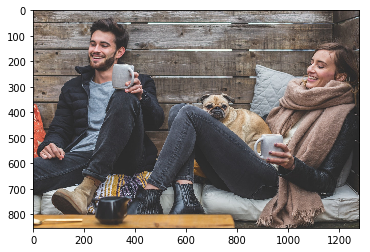

In [9]:
#demo image
img_path = '/workdir/demo_data/images/friends.jpeg'
img = sly.image.read(img_path)
plt.figure()
plt.imshow(img)

In [10]:
agent = api.agent.get_info_by_name(team.id, agent_name)
if agent is None:
    raise RuntimeError("Agent {!r} not found".format(agent_name))
if agent.status is api.agent.Status.WAITING:
    raise RuntimeError("Agent {!r} is not running".format(agent_name))

In [11]:
task_ids = api.model.get_deploy_tasks(model.id)
if len(task_ids) == 0:
    print('Model {!r} is not deployed. Deploying...'.format(model.name))
    task_id = api.task.deploy_model(agent.id, model.id)
    api.task.wait(task_id, api.task.Status.DEPLOYED)
else:
    print('Model {!r} has been already deployed'.format(model.name))
    task_id = task_ids[0]

print('Deploy task_id = {}'.format(task_id))

Model 'yolo_coco' has been already deployed
Deploy task_id = 1420


In [12]:
output_meta_json = api.model.get_output_meta(model.id)
output_meta = sly.ProjectMeta.from_json(output_meta_json)
print(output_meta)

KeyError: 'classes'

In [13]:
ann_json = api.model.inference(model.id, img)
ann = sly.Annotation.from_json(ann_json, output_meta)
print('Model has been sucessfully applied to the image')

Model has been sucessfully applied to the image


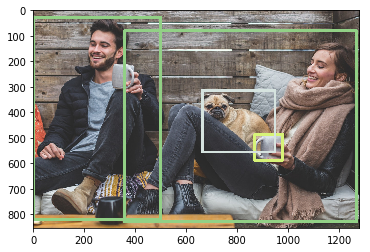

In [14]:
draw_img = np.copy(img)
ann.draw_contour(draw_img, thickness=10)
plt.figure()
plt.imshow(draw_img)